In [1]:
# Import needed libraries.
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

from impc_api import batch_solr_request, solr_request

In [2]:
def fetch_children(mp_id):
    num_found, df = solr_request(
        core='mp',
        params={
            'q': f'mp_id:"{mp_id}"',
            'fl': 'child_mp_id',
            'rows': 100
        },
        silent=True
    )

    if num_found == 0 or 'child_mp_id' not in df.columns:
        return []

    if num_found > 100:
        raise ValueError(f"Too many results found: {num_found}. Aborting.")

    df = df.explode('child_mp_id').dropna(subset=['child_mp_id'])
    return df['child_mp_id'].unique().tolist()

def fetch_all_descendants(mp_id):
    visited = set()
    queue = [mp_id]
    all_terms = [mp_id]

    while queue:
        current = queue.pop(0)
        if current in visited:
            continue
        visited.add(current)

        children = fetch_children(current)
        new_terms = [child for child in children if child not in visited]

        all_terms.extend(new_terms)
        queue.extend(new_terms)

    return all_terms

def filter_impc_mp_ids(mp_ids):
    valid_terms = []

    for mp_id in mp_ids:
        # Check MP core.
        num_found_mp, df_mp = solr_request(
            core='mp',
            params={
                'q': f'mp_id:"{mp_id}"',
                'fl': 'mp_id, mp_term',
                'rows': 100
            },
            silent=True
        )

        if num_found_mp == 1:
            # Check statistical results core.
            num_found_stat, _ = solr_request(
                core='statistical-result',
                params={
                    'q': f'mp_term_id_options:"{mp_id}"',
                    'fl': 'mp_term_id_options',
                    'rows': 1
                },
                silent=True
            )
            if num_found_stat > 0:
                valid_terms.append(mp_id)

    return valid_terms

def fetch_statistical_data(mp_id, fields):
    all_descendants = fetch_all_descendants(mp_id)
    mp_term_list = filter_impc_mp_ids(all_descendants)

    query = " OR ".join(f'mp_term_id_options:"{term}"' for term in mp_term_list)
    params = {
        'q': query,
        'fl': fields
    }

    return batch_solr_request(core='statistical-result', params=params, download=False)


def summarise_colony_significance(df, term_name):
    if df is None or df.empty:
        print(f"- {term_name.upper()}: No data found.\n")
        return

    df = df.drop(columns=['parameter_stable_id'], errors='ignore')

    # Convert lists to strings.
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, list)).any():
            df[col] = df[col].apply(str)

    df = df.drop_duplicates()

    # Save deduplicated data.
    output_dir = Path("output")
    output_dir.mkdir(exist_ok=True)

    filename = f"{term_name.lower().replace(' ', '_')}_deduplicated.csv"
    filepath = output_dir / filename
    df.to_csv(filepath, index=False)
    print(f"Saved deduplicated data to: {filepath}")

    # Calculate significance.
    grouped = df.groupby(
        ['colony_id', 'allele_symbol']
    )['significant']

    summary = grouped.any().reset_index()

    count_true = summary['significant'].sum()
    count_false = len(summary) - count_true

    print(f"- {term_name.upper()}")
    print(f"Significant lines: {count_true}")
    print(f"Non-significant lines: {count_false}")
    print(f"Total lines: {count_true + count_false}\n")

requested_fields = [
    'allele_symbol',
    'colony_id',
    'marker_symbol',
    'mp_term_id_options',
    'parameter_stable_id',
    'pipeline_stable_id',
    'significant'
]
requested_fields = ','.join(requested_fields)

## Number of lines assessed for otic vesicle morphology

In [3]:
df = fetch_statistical_data("MP:0009806", requested_fields)
summarise_colony_significance(df, "Otic vesicle morphology")

Number of found documents: 1116


5000it [00:00, 39340.43it/s]                                                                                                                                             

Saved deduplicated data to: output/otic_vesicle_morphology_deduplicated.csv
- OTIC VESICLE MORPHOLOGY
Significant lines: 7
Non-significant lines: 812
Total lines: 819



## Number of lines assessed for ABR

In [4]:
df = fetch_statistical_data('MP:0004738', requested_fields)
summarise_colony_significance(df, "Auditory brainstem response")

Number of found documents: 43941


45000it [00:02, 15331.00it/s]                                                                                                                                            

Saved deduplicated data to: output/auditory_brainstem_response_deduplicated.csv
- AUDITORY BRAINSTEM RESPONSE
Significant lines: 335
Non-significant lines: 6784
Total lines: 7119



## Number of lines examined for retinal abnormalities

In [5]:
df = fetch_statistical_data('MP:0001325', requested_fields)
summarise_colony_significance(df, "Abnormal retinal phenotype")

Number of found documents: 54872


55000it [00:03, 16340.84it/s]                                                                                                                                            

Saved deduplicated data to: output/abnormal_retinal_phenotype_deduplicated.csv
- ABNORMAL RETINAL PHENOTYPE
Significant lines: 811
Non-significant lines: 8018
Total lines: 8829



## Analyse intersection of ABR (auditory brainstem response) and GEL (otic vesicle morphology) lines / colony_ids

In [6]:
def analyse_df(df, name):
    print(f"\n{name} - Original shape: {df.shape}")
    
    # Drop columns and reset index.
    df_dropped = df.drop(columns=['mp_term_id_options', 'significant', 'pipeline_stable_id']).reset_index(drop=True)
    print(f"{name} - After dropping columns: {df_dropped.shape}")
    
    # Normalise strings (fix the deprecated applymap).
    df_normalised = df_dropped.astype(str).map(lambda x: x.strip() if isinstance(x, str) else x)
    
    # Check for duplicates before removing them.
    duplicates = df_normalised.duplicated()
    
    # Remove duplicates.
    df_unique = df_normalised.drop_duplicates()
    print(f"{name} - After removing duplicates: {df_unique.shape}")
    
    # Count unique colony_ids.
    unique_colony_ids = df_unique['colony_id'].nunique()
    unique_rows = df_unique.shape[0]
    
    print(f"{name} - Unique colony_id values: {unique_colony_ids}")
    print(f"{name} - Unique rows: {unique_rows}")
    
    # Debug: Show cases where colony_id appears multiple times.
    colony_counts = df_unique['colony_id'].value_counts()
    multiple_entries = colony_counts[colony_counts > 1]
    if len(multiple_entries) > 0:
        print(f"{name} - Colony IDs appearing multiple times:")
        for colony_id, count in multiple_entries.head(10).items():
            print(f"  {colony_id}: {count} times")
            # Show the actual rows
            matching_rows = df_unique[df_unique['colony_id'] == colony_id]
            print(f"    Rows: {matching_rows.to_string()}")
    return df_unique.drop(columns=["allele_symbol", "marker_symbol"]).reset_index(drop=True)

abr_filename = "output/auditory_brainstem_response_deduplicated.csv"
gel_filename = "output/otic_vesicle_morphology_deduplicated.csv"
abr_df = pd.read_csv(abr_filename)
gel_df = pd.read_csv(gel_filename)
abr_unique = analyse_df(abr_df, "ABR Data")
gel_unique = analyse_df(gel_df, "GEL Data")


ABR Data - Original shape: (7469, 6)
ABR Data - After dropping columns: (7469, 3)
ABR Data - After removing duplicates: (7119, 3)
ABR Data - Unique colony_id values: 7119
ABR Data - Unique rows: 7119

GEL Data - Original shape: (825, 6)
GEL Data - After dropping columns: (825, 3)
GEL Data - After removing duplicates: (819, 3)
GEL Data - Unique colony_id values: 819
GEL Data - Unique rows: 819


ABR unique lines: 7119
GEL unique lines: 819
Intersection (both): 575
ABR only: 6544
GEL only: 244


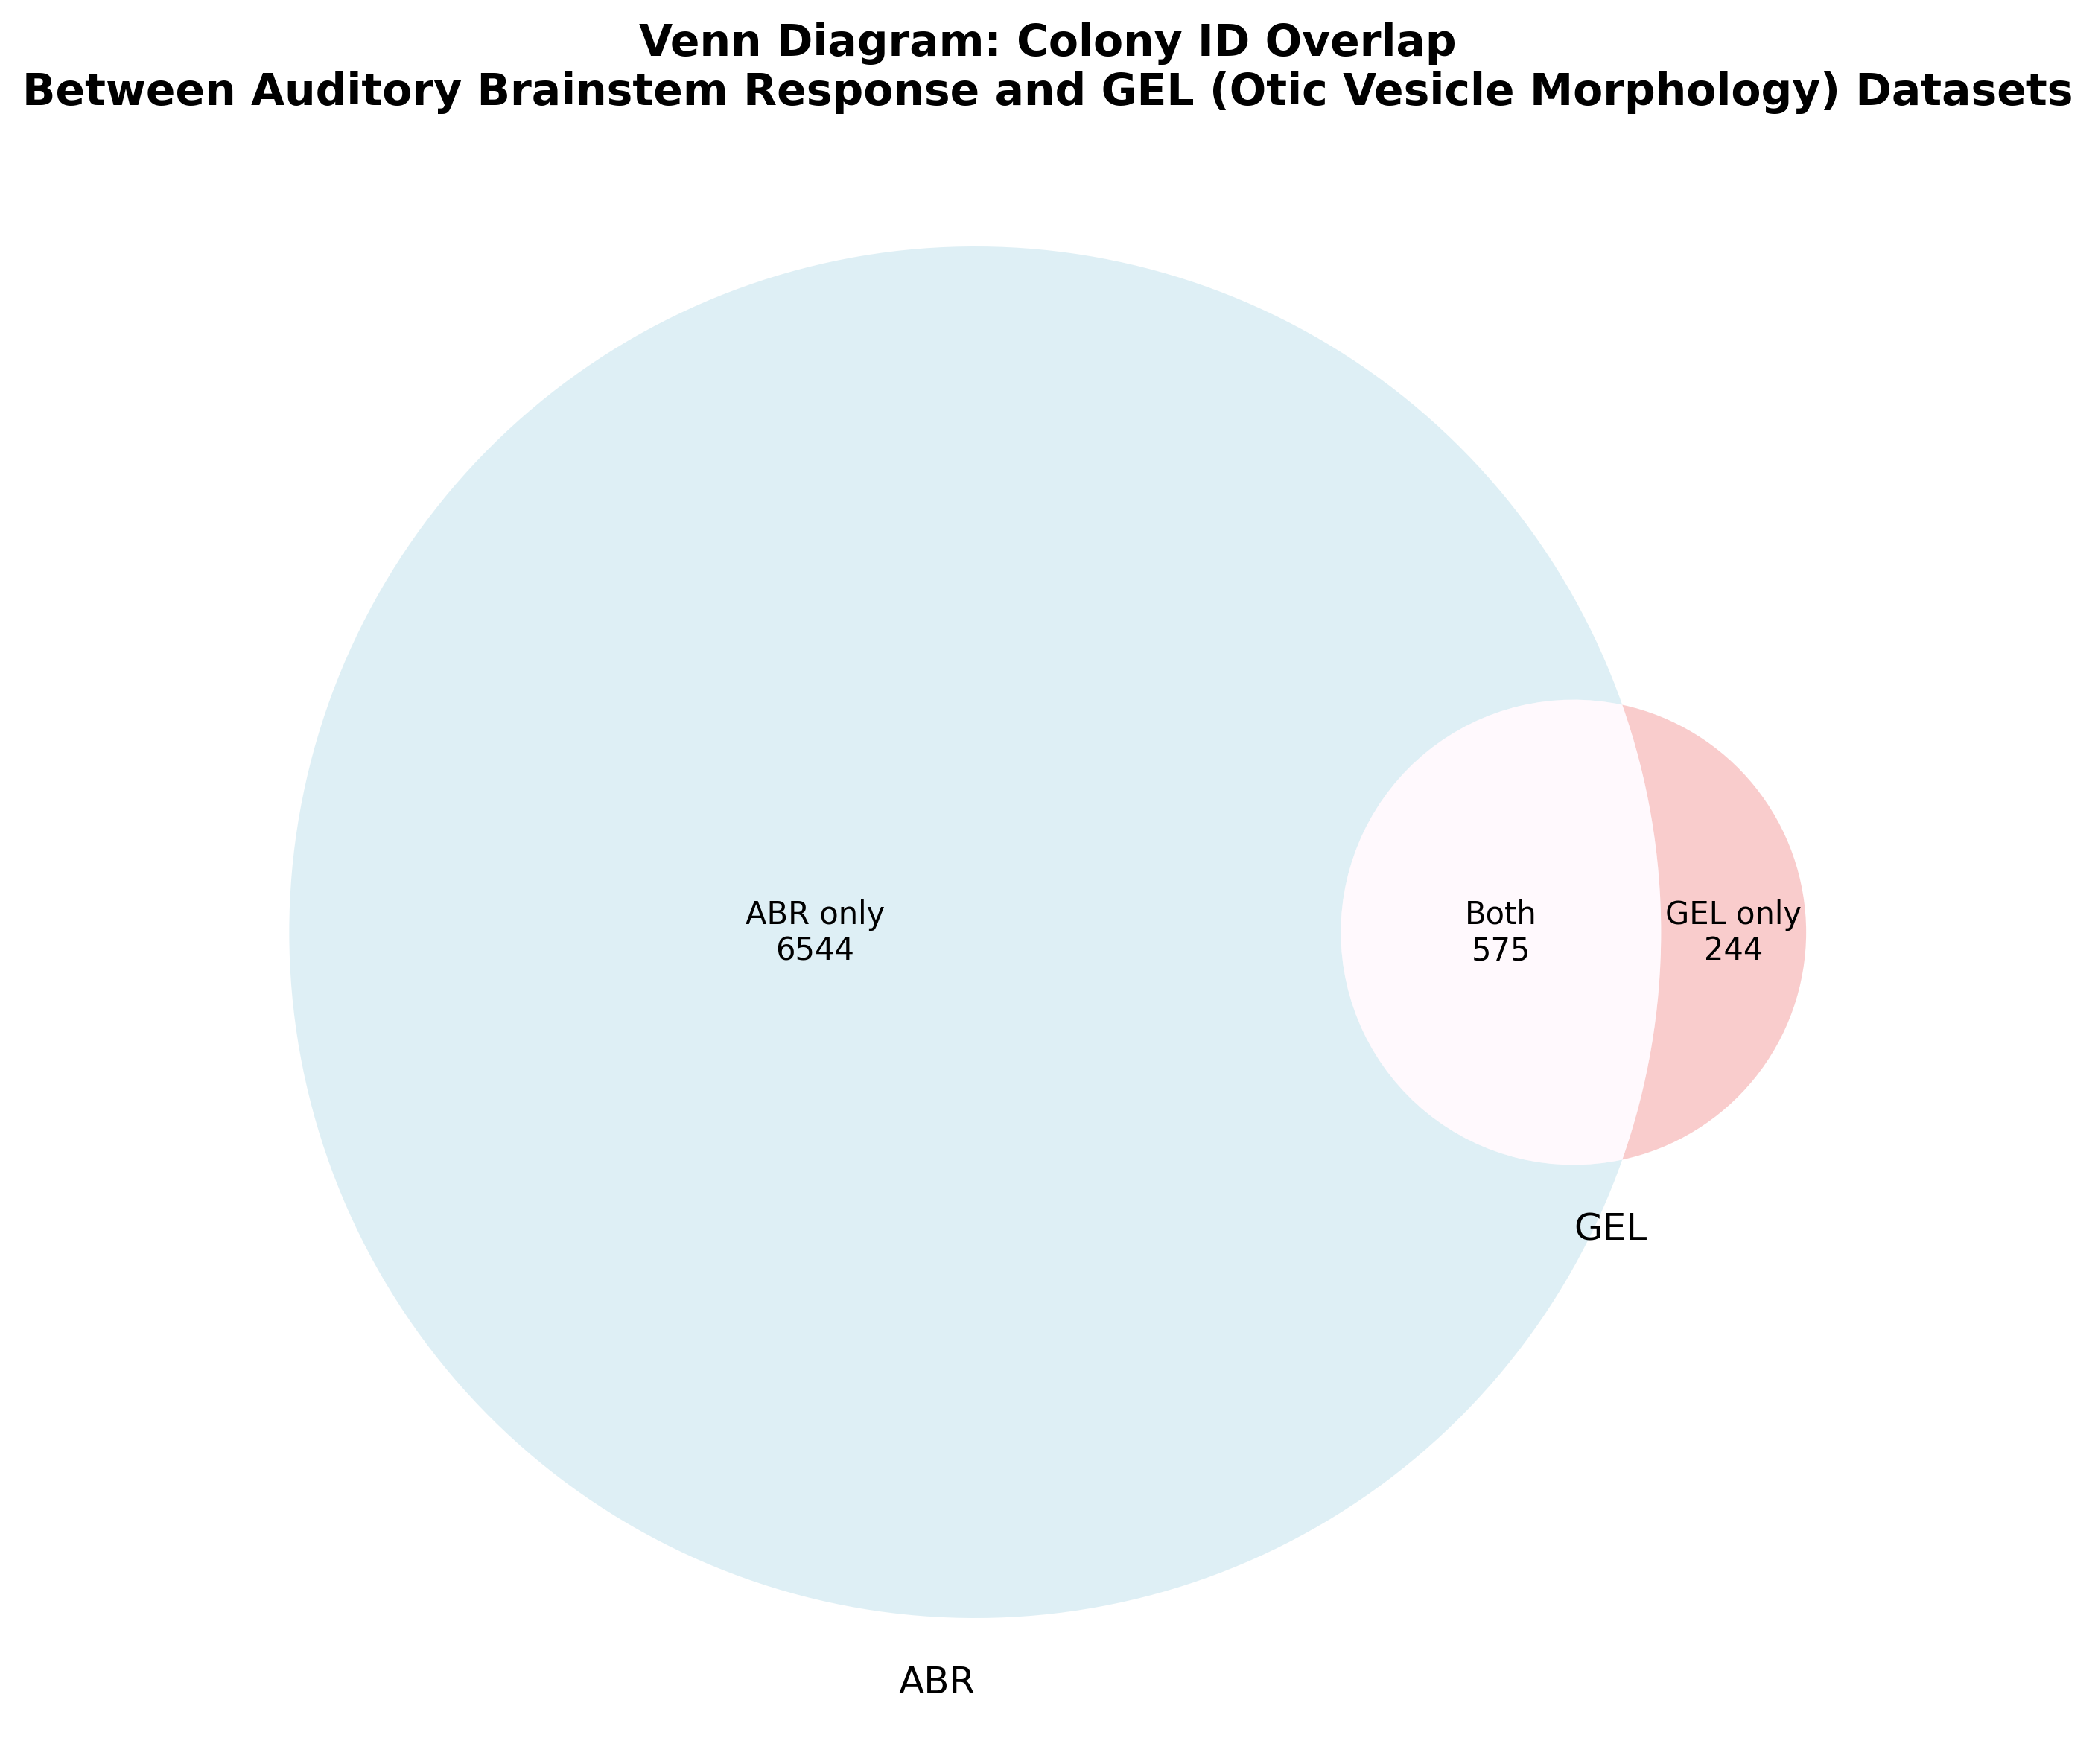

In [7]:
# Get unique values from each dataframe.
abr_markers = set(abr_unique['colony_id'].unique())
gel_markers = set(gel_unique['colony_id'].unique())

# Calculate intersection and differences.
intersection = abr_markers & gel_markers
abr_only = abr_markers - gel_markers
gel_only = gel_markers - abr_markers

# Print statistics.
print(f"ABR unique lines: {len(abr_markers)}")
print(f"GEL unique lines: {len(gel_markers)}")
print(f"Intersection (both): {len(intersection)}")
print(f"ABR only: {len(abr_only)}")
print(f"GEL only: {len(gel_only)}")

# Create Venn diagram
plt.figure(figsize=(12, 8), dpi=300)
venn = venn2([abr_markers, gel_markers], 
             set_labels=('ABR', 'GEL'),
             set_colors=('lightblue', 'lightcoral'))

# Add counts to the diagram
if venn.get_label_by_id('10'):
    venn.get_label_by_id('10').set_text(f'ABR only\n{len(abr_only)}')
if venn.get_label_by_id('01'):
    venn.get_label_by_id('01').set_text(f'GEL only\n{len(gel_only)}')
if venn.get_label_by_id('11'):
    venn.get_label_by_id('11').set_text(f'Both\n{len(intersection)}')

plt.title('Venn Diagram: Colony ID Overlap\nBetween Auditory Brainstem Response and GEL (Otic Vesicle Morphology) Datasets', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()